## Projekt 2

Zbiór danych: CIFAR-10 obrazki kolorowe, 70000 próbek, 10 klas

Celem projektu jest porównanie dwóch klasyfikatorów: klasyfikatora SVM użytego dla danych wygenerowanych przez prostą sieć CNN oraz klasyfikatora MLP. 

Trenujemy prostą kilkuwarstwową sieć CNN dla 4 czasów trenowania: bardzo krótki, krótki, średni, pełny. Sieć taką można łatwo znaleźć. (sieć CNN składa się z części konwolucyjnej i MLP, dlatego wyniki dla klasyfikatora MLP będą takie same jak dla całej sieci CNN).

Po zadanych czasach trenowania t1, t2, t3, t4, zrzucić wektory reprezentujące obrazki które wchodzą na sieć MLP. Te wektory użyć do klasyfikacji metodą SVM. 

Wyniki jakości klasyfikatorów oceniać na bazie krzyżowej-walidacji, (accuracy - Loss-błąd, Krzywa ROC, Precision-Recall, (pola pod krzywymi) F1). Dokonać porównania wyników tzn: accuracy i loss dla trzech budżetów czasowych T1, T2, T3 (krótki, średni, długi). Tym sposobem porównać jakość klasyfikatorów tj. pełnej, uczonej sieci CNN w zadanych czasach oraz tej „kombinowanej” z SVM. 

Należy sporządzić raport z projektu.

In [48]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

from sklearn.datasets import fetch_openml
from sklearn.base import ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn

from sklearn.metrics import classification_report
from sklearn.metrics import auc

import math
import time
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import load_breast_cancer, load_digits, fetch_openml, load_iris, make_moons, make_blobs
from sklearn.linear_model import LogisticRegression, LogisticRegression
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from scipy import stats

import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_curve,
                             precision_recall_curve, plot_precision_recall_curve, f1_score, average_precision_score, 
                             hinge_loss, precision_score, recall_score)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import load_breast_cancer, load_digits, fetch_openml, load_iris, make_moons, make_blobs
from sklearn.multiclass import OneVsRestClassifier
from scipy import stats
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from imgaug import augmenters as iaa
from sklearn.svm import LinearSVC
from IPython.display import display

from keras import backend as K
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cifar = fetch_openml("CIFAR_10", data_home="./CIFAR_10", cache=True)

0. airplane
1. automobile
2. bird
3. cat
4. deer
5. dog
6. frog
7. horse
8. ship
9. truck

CIFAR-10 contains 6000 images per class. The original train-test split randomly divided these into 5000 train and 1000 test images per class.

https://www.openml.org/d/40927

### const

In [146]:
batch_size = 32
num_classes = 10
epochs = 3
num_predictions = 20

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

### functions

In [138]:
def train_model(model, x_train, y_train, batch_size, epochs, x_test, y_test):
    return model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test))

def print_plots(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
def print_roc(fpr, tpr):
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='RF (area = {:.3f})'.format(auc(fpr, tpr)))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    
def maximum_predict(data):
    out = []
    for item in data:
        i = 0
        for sub_item in item:
            if sub_item == 1:
                out.append(i)
                break;
            i += 1
    return out

In [269]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train[:1000]
y_train = y_train[:1000]
x_test = x_test[:1000]
y_test = y_test[:1000]

In [270]:
# Convert class vectors to binary class matrices.
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [276]:
## print(x_train.shape)

# def rgb2gray(rgb):
#     return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

# out = []
# for index in x_train:
#     out.append(rgb2gray(img))
# x_train_grey = np.array(out)

# out = []
# for index in x_test:
#     out.append(rgb2gray(img))
# x_test_grey = np.array(out)
    
# x_train_reshaped = np.array(x_train_grey).reshape(x_train_grey.shape[0],32*32)
# x_test_reshaped = np.array(x_test_grey).reshape(x_test_grey.shape[0],32*32)

# scaler = StandardScaler()
# pca = PCA(2)

# scaler.fit(x_train_reshaped)
# x_train_scale = scaler.transform(x_train_reshaped)
# x_test_scale = scaler.transform(x_test_reshaped)

# pca.fit(x_train_reshaped)
# x_train_pca = pca.transform(x_train_scale)
# x_test_pca = pca.transform(x_test_scale)

# x_train_ = x_train_pca.reshape(x_train_grey.shape[0], 24, 24)
# x_test_ = x_train_pca.reshape(x_test_grey.shape[0], 24, 24)

In [163]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

ValueError: Input 0 is incompatible with layer conv2d_9: expected ndim=4, found ndim=2

In [52]:
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6),
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)       

In [54]:
history = train_model(model, x_train, y_train, batch_size, epochs, x_test, y_test)

Train on 1000 samples, validate on 1000 samples
Epoch 1/3
1000/1000 [==============================] - 2s 2ms/step - loss: 2.2983 - accuracy: 0.0960 - val_loss: 2.2868 - val_accuracy: 0.1610
Epoch 2/3
1000/1000 [==============================] - 1s 1ms/step - loss: 2.2724 - accuracy: 0.1620 - val_loss: 2.2586 - val_accuracy: 0.2430
Epoch 3/3
1000/1000 [==============================] - 2s 2ms/step - loss: 2.2321 - accuracy: 0.1810 - val_loss: 2.2011 - val_accuracy: 0.2400


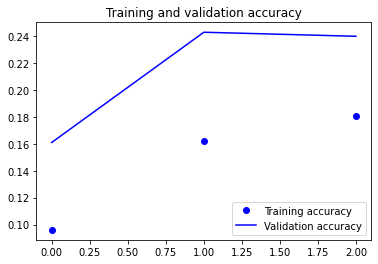

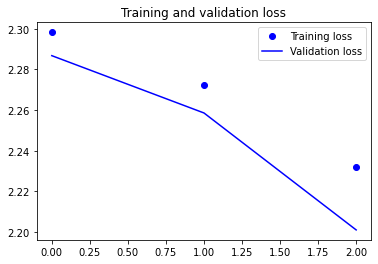

1000/1000 [==============================] - 0s 236us/step
Test loss: 2.2010599822998045
Test accuracy: 0.23999999463558197


In [55]:
print_plots(history)
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

              precision    recall  f1-score   support

           0       0.23      0.51      0.31       103
           1       0.14      0.31      0.19        89
           2       0.19      0.03      0.05       100
           3       0.00      0.00      0.00       103
           4       0.25      0.04      0.08        90
           5       0.00      0.00      0.00        86
           6       0.47      0.44      0.45       112
           7       0.23      0.20      0.21       102
           8       0.26      0.49      0.34       106
           9       0.23      0.28      0.26       109

    accuracy                           0.24      1000
   macro avg       0.20      0.23      0.19      1000
weighted avg       0.20      0.24      0.20      1000



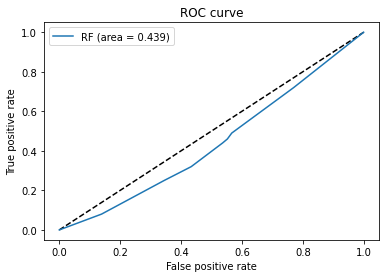

In [139]:
test_preds = model.predict_classes(x_test)
predict_result = [item for item in test_preds]
correct = maximum_predict(y_test)

print(classification_report(correct, predict_result))

fpr, tpr, thresholds = roc_curve(correct, predict_result, pos_label=2)

print_roc(fpr, tpr)

### SVM

In [144]:
def get_layer_output(index, data):
    return K.function([model.layers[0].input], [model.layers[index].output])(data)[0]

layer_output = get_layer_output(15, x_train)
clf = SVC(kernel='linear', C=10)

clf.fit(layer_output, correct)
pred = clf.predict(layer_output)

Accouracy: 0.404
hinge function loss: 2.4035080677982035
recall score: 0.404
f1 score: 0.404
precision_score: 0.404


/media/DATA/studia/ML/project/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'binary') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


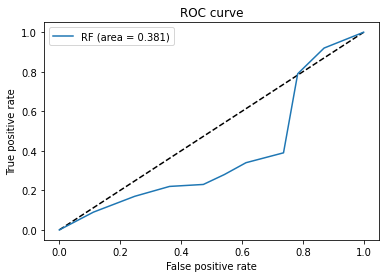

In [145]:
score = clf.score(layer_output, correct)
print(f'Accouracy: {score}')

predict = clf.decision_function(layer_output)
score = hinge_loss(correct, predict)
print(f'hinge function loss: {score}')

score = recall_score(correct, pred, pos_label="binary", average="micro")
print(f'recall score: {score}')

score = f1_score(correct, pred, pos_label="binary", average="micro")
print(f'f1 score: {score}')

score = precision_score(correct, pred, pos_label="binary", average="micro")
print(f'precision_score: {score}')

fpr, tpr, thresholds = roc_curve(correct, pred, pos_label=2)
print_roc(fpr, tpr)